# **Proyecto de pruebas A/B**
By Luisa Peña 

**Objetivo del estudio**

El propósito de esta prueba A/B es evaluar el impacto de un nuevo sistema de recomendaciones implementado en una tienda en línea internacional. Se busca determinar si este nuevo sistema mejora la conversión de los usuarios en las siguientes etapas del embudo:

- product_page (visualización de la página del producto)
- product_cart (agregado al carrito)
- purchase (compra)

El experimento compara dos grupos:

- **Grupo A (control):** sin cambios en el embudo.
- **Grupo B (experimental):** con el nuevo sistema de recomendaciones.

Se espera un aumento mínimo del 10% en la conversión en cada etapa dentro de los 14 días posteriores a la inscripción.

## **1. Preprocesamiento de los datos.**

In [35]:
#Cargar las librerias 
import pandas as pd
import math 
import numpy as np
import datetime as dt
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest as stats_proportions_ztest

In [2]:
#Cargar los archivos 
calendar_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

### Exploración inicial de los datos 

In [3]:
# Explorar los datasets, identificando datos ausentes, duplicados, y unicos. 
def explorar_dataset(df, nombre='DataFrame'):
    print(f"Información general del dataset `{nombre}`:")
    print("-" * 50)
    print(df.info())
    print()

    print("Primeras filas del dataset:")
    print("-" * 50)
    display(df.head())
    print()

    print("Revisión de datos ausentes:")
    print("-" * 50)
    print(df.isna().sum())
    print()

    print("Revisión de duplicados:")
    print("-" * 50)
    print(f"Filas duplicadas: {df.duplicated().sum()}")
    print()
    
    print("Tipos de datos únicos por columna:")
    print("-" * 50)
    print()
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} valores únicos")

In [4]:
explorar_dataset(calendar_events, 'calendar_events')

Información general del dataset `calendar_events`:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

Primeras filas del dataset:
--------------------------------------------------


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Revisión de datos ausentes:
--------------------------------------------------
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Revisión de duplicados:
--------------------------------------------------
Filas duplicadas: 0

Tipos de datos únicos por columna:
--------------------------------------------------

name: 14 valores únicos
regions: 6 valores únicos
start_dt: 14 valores únicos
finish_dt: 14 valores únicos


**Conclusiones: `calendar_events`**
- Contiene 14 registros únicos sobre campañas de marketing.
- No hay datos ausentes ni duplicados.
- Las fechas están en formato object (texto) y deberían convertirse a datetime (start_dt y finish_dt).

In [5]:
explorar_dataset(new_users, 'new_users')

Información general del dataset `new_users`:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None

Primeras filas del dataset:
--------------------------------------------------


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Revisión de datos ausentes:
--------------------------------------------------
user_id       0
first_date    0
region        0
device        0
dtype: int64

Revisión de duplicados:
--------------------------------------------------
Filas duplicadas: 0

Tipos de datos únicos por columna:
--------------------------------------------------

user_id: 58703 valores únicos
first_date: 17 valores únicos
region: 4 valores únicos
device: 4 valores únicos


**Conclusiones: `new_users`**
- Tiene 58.703 usuarios únicos, sin datos faltantes ni duplicados.
- Las fechas (first_date) están en formato object → deben convertirse a datetime.
- Hay 4 valores únicos en region y device. Conviene analizarlos más adelante por segmentación.

In [6]:
explorar_dataset(events, 'events')

Información general del dataset `events`:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None

Primeras filas del dataset:
--------------------------------------------------


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



Revisión de datos ausentes:
--------------------------------------------------
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

Revisión de duplicados:
--------------------------------------------------
Filas duplicadas: 0

Tipos de datos únicos por columna:
--------------------------------------------------

user_id: 58703 valores únicos
event_dt: 257138 valores únicos
event_name: 4 valores únicos
details: 4 valores únicos


**Conclusiones: `events`**
- Tiene 423.761 eventos asociados a los nuevos usuarios.
- No hay duplicados ni valores nulos en las columnas principales.
- La columna details tiene muchos nulos (~85%), pero esto es esperable, porque solo aplica para el evento purchase.
- Los valores únicos de event_name son 4 → revisaremos luego si hay algún evento inesperado.
- event_dt está como object, y debe convertirse a datetime.

In [7]:
explorar_dataset(participants, 'participants')

Información general del dataset `participants`:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None

Primeras filas del dataset:
--------------------------------------------------


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test



Revisión de datos ausentes:
--------------------------------------------------
user_id    0
group      0
ab_test    0
dtype: int64

Revisión de duplicados:
--------------------------------------------------
Filas duplicadas: 0

Tipos de datos únicos por columna:
--------------------------------------------------

user_id: 13638 valores únicos
group: 2 valores únicos
ab_test: 2 valores únicos


**Conclusiones: `participants`**
- Contiene 14.525 registros, sin duplicados ni valores nulos.
- Sin embargo, la columna user_id tiene solo 13.638 valores únicos, lo que indica usuarios duplicados en el test.
- group tiene 2 valores (A y B), lo esperado.
- ab_test también tiene 2 valores únicos, deberíamos filtrar solo la prueba 'recommender_system_test'.

In [8]:
# Convertir columnas de fecha a tipo datetime
calendar_events['start_dt'] = pd.to_datetime(calendar_events['start_dt'])
calendar_events['finish_dt'] = pd.to_datetime(calendar_events['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])


In [9]:
# Verificar que los datos sea datetime en los casos necesarios
print(calendar_events.info())
print(new_users.info())
print(events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data colu

### Conclusiones Generales: 

* Se detectaron tipos de datos incorrectos en las columnas de fecha, que fueron convertidos al tipo datetime para facilitar el análisis temporal.
* En cuanto a valores ausentes, solo la columna **details** del dataset events contiene valores nulos, lo cual es esperado y no requiere limpieza adicional.
* No se detectaron filas duplicadas en los datasets. Sin embargo, el dataset `participants` contiene usuarios que están asignados a más de un grupo experimental, lo cual representa un riesgo de contaminación en la prueba A/B. Este caso se analizará en detalle en el EDA, ya que puede indicar usuarios presentes en más de un grupo, lo cual puede afectar directamente la validez de la prueba. 

## **2. Analisis Exploratorio de datos (EDA)**

In [10]:
# Usuarios por grupo
group_counts = participants['group'].value_counts()
print("Usuarios por grupo:")
print(group_counts)

Usuarios por grupo:
A    8214
B    6311
Name: group, dtype: int64


In [11]:
# ¿Hay usuarios que están presentes en ambas muestras?
# Contar usuarios únicos
total_users = participants['user_id'].nunique()
total_rows = participants.shape[0]
print(f"Registros: {total_rows}")
print(f"Usuarios únicos: {total_users}")

# Revisar si hay usuarios en ambos grupos
user_group_counts = participants.groupby('user_id')['group'].nunique()
duplicated_users = user_group_counts[user_group_counts > 1]
print(f"Usuarios en ambos grupos: {len(duplicated_users)}")


Registros: 14525
Usuarios únicos: 13638
Usuarios en ambos grupos: 441


In [27]:
# Conversión en las diferentes etapas del embudo 

# Conversión general por evento
conversion_counts = events['event_name'].value_counts()
print(conversion_counts)
print()

# Conversión única por usuario y evento
conversion_by_user = events.groupby(['user_id', 'event_name']).size().unstack(fill_value=0)
print(conversion_by_user.head())
print()

# Porcentaje de conversión por etapa
total_users_event = events.groupby('event_name')['user_id'].nunique()
print(total_users_event)
print()

step1 = total_users_event['product_page']
step2 = total_users_event['product_cart'] / step1 * 100
step3 = total_users_event['purchase'] / total_users_event['product_cart'] * 100
print(f"Conversión product_page → product_cart: {step2:.2f}%")
print(f"Conversión product_cart → purchase: {step3:.2f}%")

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

event_name        login  product_cart  product_page  purchase
user_id                                                      
0001710F4DDB1D1B      2             2             2         0
000199F1887AE5E6      4             4             4         4
0002499E372175C7      3             0             3         3
0002CE61FF2C4011      4             4             4         0
000456437D0EFFE1      2             0             2         0

event_name
login           58696
product_cart    19284
product_page    38929
purchase        19568
Name: user_id, dtype: int64

Conversión product_page → product_cart: 49.54%
Conversión product_cart → purchase: 101.47%


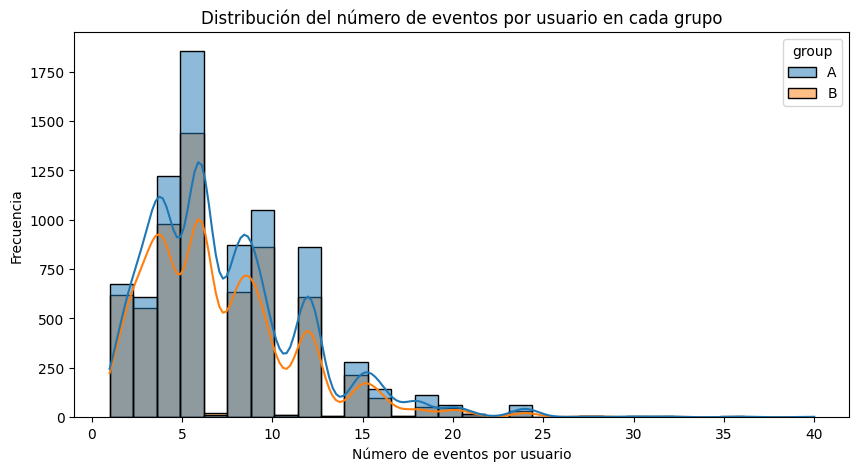

In [14]:
# ¿Los eventos por usuario están distribuidos equitativamente?
# Unir eventos con grupos de prueba 
events_merged = events.merge(participants, on='user_id', how='left')
# Contar eventos por grupo 
events_per_user = events_merged.groupby(['group', 'user_id'])['event_name'].count().reset_index()
# Ver distribución por grupo 
plt.figure(figsize=(10, 5))
sns.histplot(data=events_per_user, x='event_name', hue='group', kde=True, bins=30)
plt.title("Distribución del número de eventos por usuario en cada grupo")
plt.xlabel("Número de eventos por usuario")
plt.ylabel("Frecuencia")
plt.show()

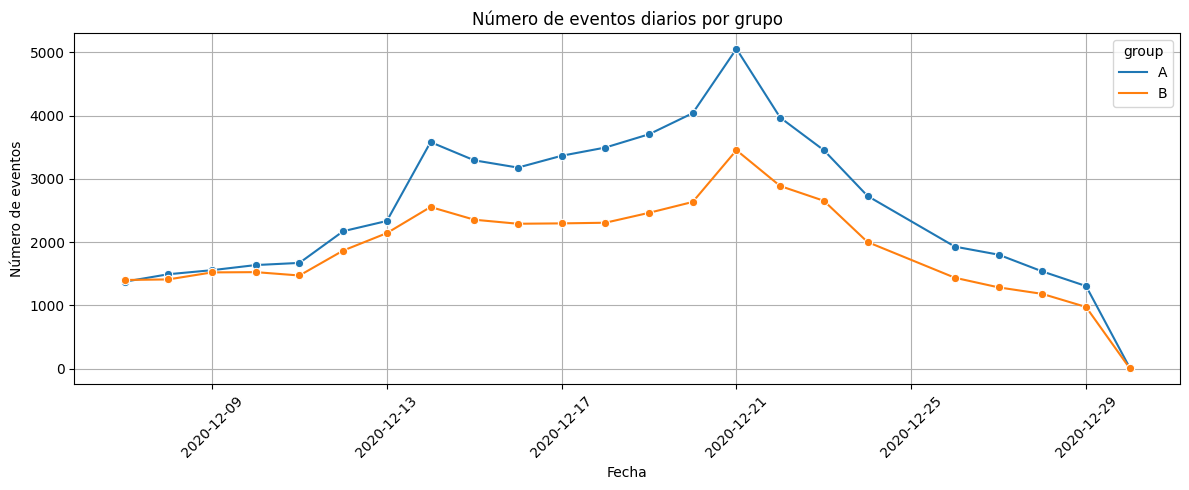

In [16]:
# Crear columna con solo la fecha (sin hora)
events_merged['date'] = events_merged['event_dt'].dt.date

# Contar eventos diarios por grupo
daily_events = events_merged.groupby(['date', 'group'])['event_name'].count().reset_index()

# Graficar
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_events, x='date', y='event_name', hue='group', marker='o')
plt.title("Número de eventos diarios por grupo")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Revisar fechas mínimas y máximas
print(events['event_dt'].min())
print(events['event_dt'].max())

# Eventos por grupo
print(events_merged['group'].value_counts())


2020-12-07 00:00:33
2020-12-30 23:36:33
A    58705
B    44133
Name: group, dtype: int64


In [18]:
# Total de eventos por grupo
event_counts = events_merged['group'].value_counts()

# Total de usuarios por grupo
user_counts = participants['group'].value_counts()

# Promedio de eventos por usuario en cada grupo
avg_events_per_user = event_counts / user_counts
print("Promedio de eventos por usuario:")
print(avg_events_per_user)


Promedio de eventos por usuario:
A    7.146944
B    6.993028
Name: group, dtype: float64


Nota: El promedio de eventos por usuario es ligeramente mayor en el grupo A (7.15) que en el grupo B (6.99). Aunque esta diferencia no es dramática, puede ser útil considerarla al interpretar los resultados del experimento.

**Conclusiones del Analisis Exploratorio de Datos (EDA)**

**Usuarios participantes en la prueba A/B:**

- Hay 14.525 registros en el dataset participants, pero solo 13.638 usuarios únicos.
- Se identificaron 441 usuarios duplicados, es decir, usuarios que aparecen tanto en el grupo A como en el grupo B, lo que representa una contaminación del experimento. Estos usuarios deberán ser excluidos del análisis estadístico para asegurar la validez de la prueba.

**Eventos de los usuarios:**

- En total se registraron 423.761 eventos, de los cuales los más frecuentes fueron login, product_page, product_cart y purchase.
- Al calcular conversiones únicas por usuario:
  * 49.54% de los usuarios que vieron una página de producto (product_page) añadieron un producto al carrito (product_cart).
  * 101.47% de los usuarios que añadieron al carrito completaron una compra, lo cual es una inconsistencia. Este resultado se debe probablemente a usuarios duplicados o errores en la secuencia de eventos, que deben ser revisados más adelante.

**Distribución de eventos por usuario:**

- La mayoría de los usuarios tiene entre 2 y 10 eventos, con una distribución similar entre los grupos A y B.
- No se observan diferencias visuales drásticas entre los grupos, aunque grupo A parece tener una leve mayor actividad en general.

**Eventos diarios por grupo:**

- El volumen de eventos muestra una tendencia creciente hasta el 21 de diciembre, seguido de una caída progresiva hasta final de mes.
- Ambos grupos siguen un patrón similar, aunque el grupo A presenta un volumen de eventos diario consistentemente superior.
- Todos los eventos están contenidos entre el 7 de diciembre y el 30 de diciembre de 2020, lo cual esta bien para poder hacer comparaciones entre los grupos en tiempos iguales. 

## **3. Evaluación de los resultados de la prueba A/B**

In [20]:
# Filtrar los datos para eliminar los 441 usuarios contaminados
# Filtrar participantes y eventos
participants_clean = participants[~participants['user_id'].isin(duplicated_users)]
events_clean = events[~events['user_id'].isin(duplicated_users)]

# Unir eventos y grupos limpios
events_merged_clean = events_clean.merge(participants_clean, on='user_id', how='left')
events_merged_clean.head()

,user_id,event_dt,event_name,details,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,NaN,NaN


In [30]:
# Filtro solo eventos del embudo y datos limpios
funnel_events = ['product_page', 'product_cart', 'purchase']
df = events_merged_clean[events_merged_clean['event_name'].isin(funnel_events)].copy()

# Crear conjuntos por grupo y evento
def get_user_sets(df, group):
    sub = df[df['group'] == group]
    page = set(sub[sub['event_name'] == 'product_page']['user_id'])
    cart = set(sub[sub['event_name'] == 'product_cart']['user_id'])
    purchase = set(sub[sub['event_name'] == 'purchase']['user_id'])
    return page, cart, purchase

A_page, A_cart, A_purchase = get_user_sets(df, 'A')
B_page, B_cart, B_purchase = get_user_sets(df, 'B')

def conversion_metrics(page, cart, purchase):
    a = len(page & cart) / len(page) * 100
    b = len(cart & purchase) / len(cart) * 100
    c = len(page & purchase) / len(page) * 100
    return round(a, 2), round(b, 2), round(c, 2)

a1, a2, a3 = conversion_metrics(A_page, A_cart, A_purchase)
b1, b2, b3 = conversion_metrics(B_page, B_cart, B_purchase)

print(f"Grupo A — page→cart: {a1}%, cart→purchase: {a2}%, page→purchase: {a3}%")
print(f"Grupo B — page→cart: {b1}%, cart→purchase: {b2}%, page→purchase: {b3}%")

Grupo A — page→cart: 31.47%, cart→purchase: 33.51%, page→purchase: 35.43%
Grupo B — page→cart: 32.99%, cart→purchase: 32.5%, page→purchase: 34.14%


In [38]:
# Pruebas Z
# Definir cantidades con base en tus conjuntos
view_A = len(A_page)
cart_A = len(A_page & A_cart)
purchase_from_cart_A = len(A_cart & A_purchase)
purchase_A = len(A_page & A_purchase)

view_B = len(B_page)
cart_B = len(B_page & B_cart)
purchase_from_cart_B = len(B_cart & B_purchase)
purchase_B = len(B_page & B_purchase)

# Nivel de significancia
alpha = 0.05

# 1. Comparación: product_page → product_cart
z1, p1 = stats_proportions_ztest([cart_A, cart_B], [view_A, view_B])
print("Comparación: page → cart")
print(f"Estadístico z: {z1:.4f}, Valor p: {p1:.4f}")
if p1 < alpha:
    print("Rechazar la hipótesis nula: hay diferencia significativa.")
else:
    print("No se pudo rechazar la hipótesis nula: no hay diferencia significativa.")

# 2. Comparación: product_cart → purchase
z2, p2 = stats_proportions_ztest([purchase_from_cart_A, purchase_from_cart_B], [len(A_cart), len(B_cart)])
print("\nComparación: cart → purchase")
print(f"Estadístico z: {z2:.4f}, Valor p: {p2:.4f}")
if p2 < alpha:
    print("Rechazar la hipótesis nula: hay diferencia significativa.")
else:
    print("No se pudo rechazar la hipótesis nula: no hay diferencia significativa.")

# 3. Comparación: product_page → purchase
z3, p3 = stats_proportions_ztest([purchase_A, purchase_B], [view_A, view_B])
print("\nComparación: page → purchase (completo)")
print(f"Estadístico z: {z3:.4f}, Valor p: {p3:.4f}")
if p3 < alpha:
    print("Rechazar la hipótesis nula: hay diferencia significativa.")
else:
    print("No se pudo rechazar la hipótesis nula: no hay diferencia significativa.")


Comparación: page → cart
Estadístico z: -1.5463, Valor p: 0.1220
No se pudo rechazar la hipótesis nula: no hay diferencia significativa.

Comparación: cart → purchase
Estadístico z: 0.7176, Valor p: 0.4730
No se pudo rechazar la hipótesis nula: no hay diferencia significativa.

Comparación: page → purchase (completo)
Estadístico z: 1.2780, Valor p: 0.2012
No se pudo rechazar la hipótesis nula: no hay diferencia significativa.


## **4. Conclusiones de la Prueba A/B**

Se realizó una prueba A/B para evaluar el impacto de un nuevo sistema de recomendaciones en el comportamiento de los usuarios. Se utilizó la prueba Z porque comparamos proporciones, tenemos muestras grandes y porque nos sirve para evaluar si la diferencia entre grupos es estadisticamente signicativa. 

El análisis reveló que 441 usuarios estaban presentes en ambos grupos experimentales, lo cual representa una posible fuente de contaminación. Estos usuarios fueron excluidos del análisis final para mantener la validez estadística.

Se evaluó el embudo de conversión completo:
`product_page` → `product_cart` → `purchase`.

Las tasas de conversión entre los grupos A (control) y B (nuevo sistema) mostraron pequeñas diferencias, pero ninguna fue estadísticamente significativa (valor p > 0.05 en todos los casos). Es decir,  los resultados de las pruebas Z indican que no hay diferencias estadísticamente significativas entre los grupos en ninguna de las etapas del embudo, dado que los valores p en todos los casos son mayores al umbral de significancia (α = 0.05).

**Recomendaciones**
---
- No implementar aún el nuevo sistema de recomendaciones, ya que no se ha demostrado una mejora clara y significativa en el comportamiento de los usuarios.
- Realizar una nueva prueba A/B considerando:
- Un mayor tamaño de muestra para aumentar el poder estadístico.
- Asegurar que los usuarios no se repitan entre grupos, para evitar contaminación.
- Medir otros indicadores de valor como: tiempo de permanencia, tasa de retorno o valor promedio de compra.
- Complementar este análisis con una evaluación cualitativa (UX, encuestas o pruebas de usabilidad) del nuevo sistema de recomendaciones para entender por qué no generó mejoras.